In [1]:
import pandas as pd
import numpy as np
from invertiblewavelets import Transform, LinearFilterBank, DyadicFilterBank
import matplotlib.pyplot as plt
from invertiblewavelets import *

#### Load Example Data from Swarm A Spacecraft Magnetoemter

In [2]:
data = np.load("data.npy")
#data = np.concatenate((data, data), axis=0)  # Duplicate the data to create two channels

# Adding some noise
sample_rate = 50.0                          # 50 Hz sampling rate
num_samples = data.shape[-1]                # 5000 samples
t = np.arange(num_samples) / sample_rate    # time array

B1 = data + 100 *np.sin(2 * np.pi * 6.4 * t) + 50 * np.sin(2 * np.pi * 12.8 * t)
B2 = data + 400 *np.sin(2 * np.pi * 6.4 * t) #+ 10*np.sin(2 * np.pi * 12.8 * t)
B = np.vstack((B1,B2))


#### Create Transform Object and Analysis Filters

In [14]:
fb = DyadicFilterBank(wavelet=Cauchy(1000) , fs=sample_rate, N=4*num_samples, real=False, s_max = 10, dj = 1/12)

transform = Transform(
    data=B[0],
    fs = sample_rate,
    filterbank=fb,
    #pad_method='None', # Padding method for the convolution calls np.pad. Set to None if no padding
)
print(fb.s_max)

10


In [15]:
transform.channel_freqs

array([ 0.0975,  0.1   ,  0.105 ,  0.1125,  0.12  ,  0.125 ,  0.1325,
        0.1425,  0.15  ,  0.1575,  0.1675,  0.1775,  0.19  ,  0.2   ,
        0.2125,  0.225 ,  0.2375,  0.2525,  0.2675,  0.2825,  0.3   ,
        0.3175,  0.3375,  0.3575,  0.3775,  0.4   ,  0.425 ,  0.45  ,
        0.475 ,  0.505 ,  0.535 ,  0.565 ,  0.6   ,  0.635 ,  0.6725,
        0.7125,  0.755 ,  0.8   ,  0.8475,  0.8975,  0.9525,  1.0075,
        1.0675,  1.1325,  1.1975,  1.27  ,  1.345 ,  1.425 ,  1.51  ,
        1.6   ,  1.695 ,  1.795 ,  1.9025,  2.015 ,  2.135 ,  2.2625,
        2.3975,  2.54  ,  2.69  ,  2.85  ,  3.02  ,  3.2   ,  3.39  ,
        3.5925,  3.805 ,  4.0325,  4.2725,  4.525 ,  4.795 ,  5.08  ,
        5.3825,  5.7025,  6.04  ,  6.4   ,  6.78  ,  7.185 ,  7.61  ,
        8.0625,  8.5425,  9.05  ,  9.59  , 10.16  , 10.7625, 11.4025,
       12.0825, 12.8   , 13.56  , 14.3675, 15.2225, 16.1275, 17.085 ,
       18.1025, 19.1775, 20.3175, 21.5275, 22.8075, 24.1625, 24.9975])

Text(0.5, 0, 'Frequency Channel')

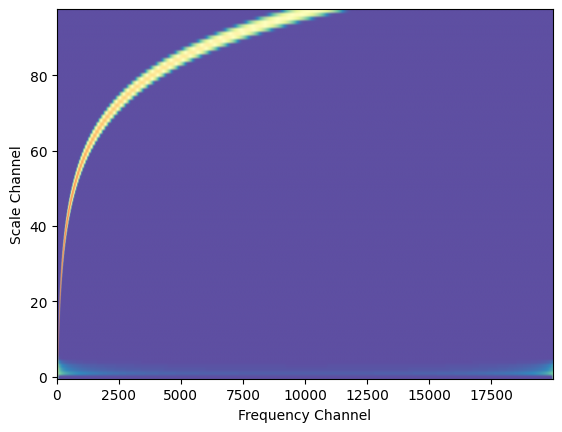

In [16]:
fig, ax = plt.subplots(1,1)
ax.imshow(np.log(np.abs(transform.Wfreq)+1e-3), aspect='auto', origin='lower', cmap='Spectral_r')
ax.set_ylabel('Scale Channel')
ax.set_xlabel('Frequency Channel')

(13281.090531329066+2368.445896952747j)


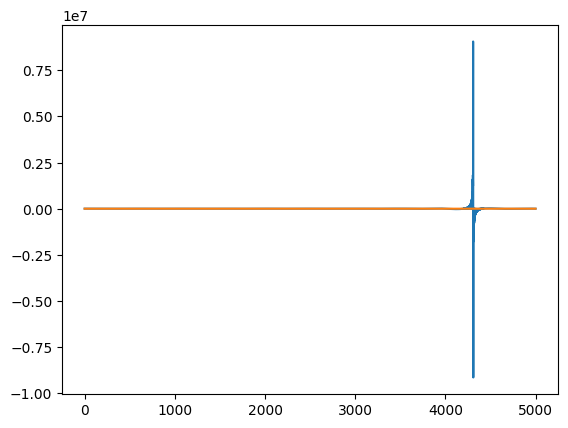

In [17]:
coeffs = transform.forward(data)
result = transform.inverse(coeffs)
print(np.mean(np.sqrt((result - data)**2)))
plt.plot(result)
plt.plot(data)

In [ ]:
plt.imshow(np.log(np.abs(coeffs)+1e-5), aspect='auto', origin='lower', interpolation='none')

#### Transform


In [ ]:
# Perform forward wavelet transform
w1 = transform.forward(B[0])
w2 = transform.forward(B[1])

D = w2 - w1  # shape (J, T), complex

# 1) correlations (eqs 6–7), using conjugate inner products
C1 = np.sum( D * np.conj(w1), axis=1 )   # shape (J,)
C2 = np.sum( D * np.conj(w2), axis=1 )   # shape (J,)

# 2) gain estimate K̂ per scale (eq 8)
K_hat = C2 / C1                          # shape (J,)
# (optionally force to real if you know K is real:)
K_hat = K_hat

# 3) stray‑field estimate A(s,τ) (eq 9)
A = D / (K_hat[:,None] - 1)              # shape (J, T), complex

# 4) ambient‑field estimate X(s,τ) (eq 10)
X = (K_hat[:,None]*w1 - w2) / (K_hat[:,None] - 1) 

result = transform.inverse(np.copy(X))


In [ ]:
print("Raw Error: ", np.sqrt(((B[0,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Raw Error: ", np.sqrt(((B[1,200:-200]-result[200:-200])**2).mean(axis=0)))
print("Cleaned Error: ", np.sqrt(((data[1000:-1000]-result[1000:-1000])**2).mean(axis=0)))

fig, ax = plt.subplots(2,1)

ax[0].legend()
ax[0].plot(B[0])
ax[0].plot(data)
ax[1].plot(result)
ax[1].plot(data)

In [ ]:
transform.scalogram(X, vmin=0, interpolation='none')
transform.scalogram(w2,vmin=0, interpolation='none')

#### Compare to Normal WAICUP

In [ ]:
from magprime.algorithms import WAICUP
%matplotlib inline
WAICUP.fs = sample_rate
WAICUP.detrend= False
result_baseline = WAICUP.clean(B, triaxial=False)
print(np.sqrt(((data-result_baseline)**2).mean(axis=0)))
print(np.sqrt(((data-result)**2).mean(axis=0)))
plt.plot(data, label='data')
plt.plot(result, label='result')
plt.plot(result_baseline, label='result_baseline')
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 5000
# sample spacing
T = 1.0 / 50
x = np.linspace(0.0, N*T, N)
y = data
yf = scipy.fftpack.fft(y)
yf2 = scipy.fftpack.fft(result)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf2[:N//2]))
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))


ax.set_yscale('log')
plt.show()


In [ ]:
fig, ax = plt.subplots(2,1)
i = 0
N = w1.shape[-1]
freqs = np.fft.fftfreq(N, d=1/sample_rate)
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i][:N//2]))
ax[0].plot(freqs[:N//2], np.abs(transform.Wfreq[i+1][:N//2]))
ax[1].plot(freqs[:N//2], np.abs(np.fft.fft(w1, axis=1))[i][:N//2])
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xscale('log')
ax[1].set_xscale('log')